# Title

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
from decouple import config

sys.path.append(config('PYTHONPATH'))

from sqlalchemy import create_engine
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from cargo.modeling.classifiers import DecisionTreeClassifier

In [2]:
engine = create_engine(config('ENGINE_PATH'))
df = pd.read_sql_table('covid', schema='research', con=engine)

In [3]:
output_notebook()
y_drop = df['price_change']
y_recovery = df['price_change_mar_may']
tops_drop, edges_drop = np.histogram(y_drop.dropna(), bins=78, range=(-1, 1), density=True)
tops_recovery, edges_recovery = np.histogram(y_recovery.dropna(), bins=78, range=(-1, 1), density=True)

p = figure(
    title="COVID-19 Returns", 
    x_axis_label='Price Growth (Fraction)',
    y_axis_label='Density (%)',
    plot_height=467, 
)
p.quad(top=tops_drop, bottom=0, left=edges_drop[:-1], right=edges_drop[1:], color=(230, 54, 54, 0.9), line_color="white", legend_label='Drop (Feb 20 - Mar 23)')
p.quad(top=tops_recovery, bottom=0, left=edges_recovery[:-1], right=edges_recovery[1:], color=(37, 93, 128, 0.5), line_color="white", legend_label='Recovery (Mar 23 - May 1)')
p.y_range.start = 0
p.xaxis.axis_label_text_font_size = '16px'
p.yaxis.axis_label_text_font_size = '16px'
p.title.text_font_size = '20pt'

show(p)

In [4]:
from sklearn.impute import SimpleImputer
from sklearn import tree
si = SimpleImputer(strategy='median')
df_55 = df.copy()
df_55['target'] = df_55.apply(lambda x: (x.price_change <= -0.25) and (x.price_change_mar_may >= 0.25), axis=1).astype(float)
X = df_55[[col for col in df_55 if df_55[col].dtype == 'float64']].copy()
X.drop(columns=['price_change', 'price_march', 'price_may', 'price_change_mar_may', 'price_february', 'price', 'cmp_eps_growth', 'cf_change_in_payables'], inplace=True)
X = pd.DataFrame(si.fit_transform(X), columns = X.columns)
y = X.pop('target')
X = X.iloc[:, :]
params = {
    'max_depth': 10,
    'min_samples_leaf': 5,
    'max_leaf_nodes': 10,
}
clf = DecisionTreeClassifier(**params)
clf = clf.fit(X, y)
clf.score(X, y)

0.9122923588039867

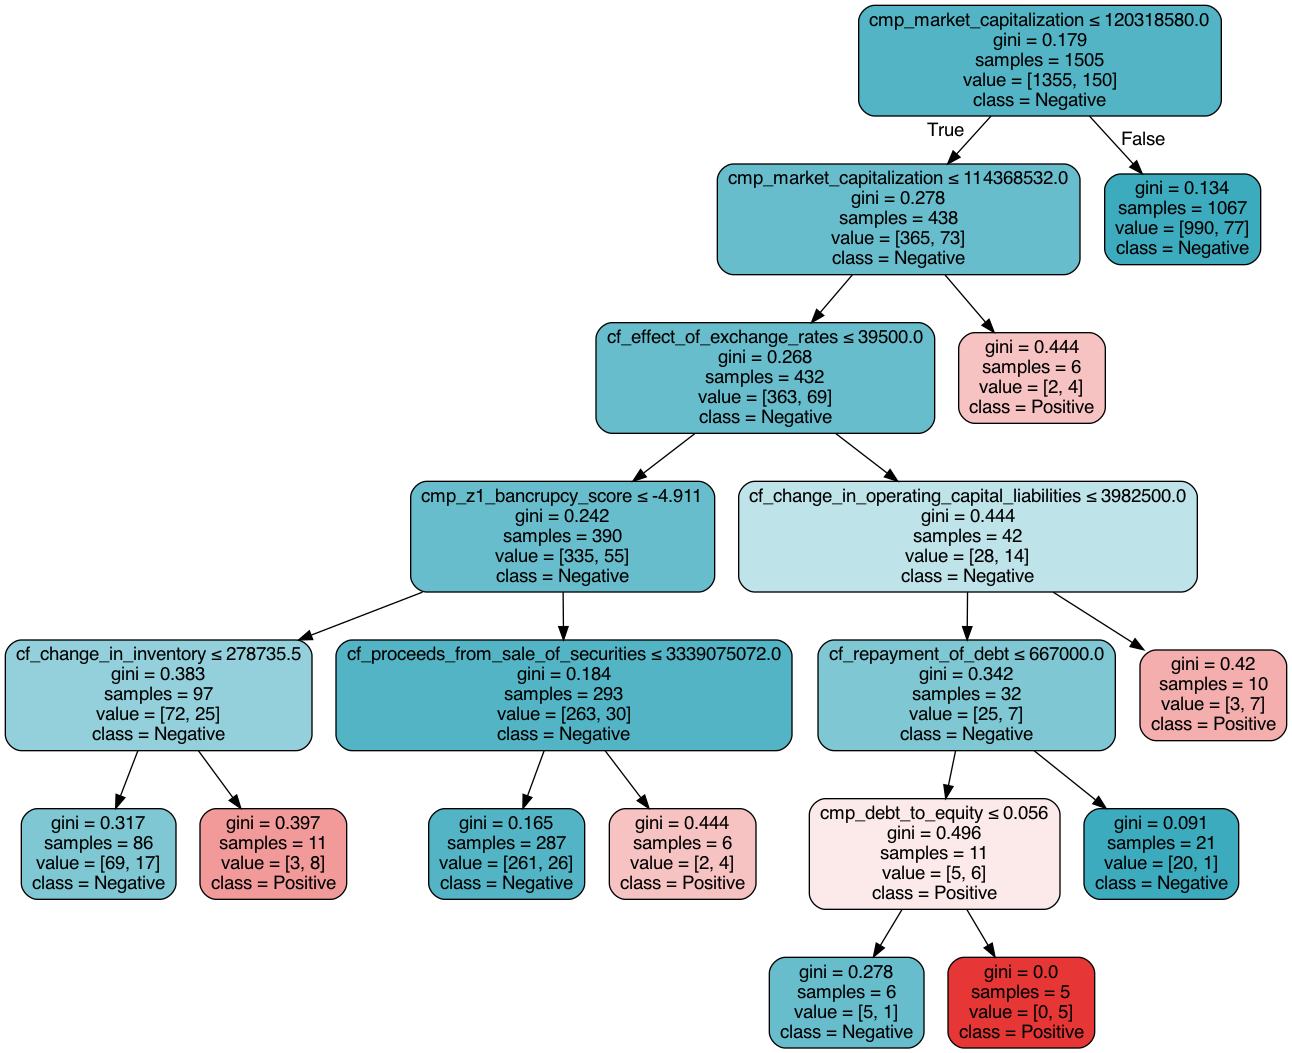

In [6]:
clf.feature_importance(X)
clf.visualize(feature_names = X.columns, save_to=os.path.join(config('PYTHONPATH'), 'cache/graph.png'))

In [ ]:
sum(df['price_change'] <= -0.25)